In [1]:
# Imports and Setup
import torch
import numpy as np
from kan import KAN as PyKAN
from kan.MLP import MLP
from efficient_kan import KAN as EfficientKAN
import matplotlib.pyplot as plt
from synthgen import SyntheticDatasetGenerator

# Set random seeds for reproducibility 
torch.manual_seed(42)
np.random.seed(42)

# Generate synthetic data
stock_data = SyntheticDatasetGenerator(length=1000)
stock_data.add_sin_wave(amplitude=1, frequency=100)
stock_data.add_sin_wave(amplitude=2, frequency=20)
stock_data.add_sin_wave(amplitude=5, frequency=10)
stock_data.add_sin_wave(amplitude=8, frequency=5)
stock_data.add_sin_wave(amplitude=10, frequency=4)
stock_data.add_exponential_growth(1.0045)

# Store clean signal
ground_truth = stock_data.data.copy()

# Add noise
stock_data.add_noise(mean=2, std=1)
noisy_signal = stock_data.data

# Normalize the data
data_mean = torch.mean(torch.FloatTensor(noisy_signal))
data_std = torch.std(torch.FloatTensor(noisy_signal))
normalized_signal = (torch.FloatTensor(noisy_signal) - data_mean) / data_std
normalized_ground_truth = (torch.FloatTensor(ground_truth) - data_mean) / data_std

# Normalize time indices to [0,1] range
time_indices = torch.arange(len(noisy_signal), dtype=torch.float32).reshape(-1, 1)
time_indices = time_indices / len(noisy_signal)

# Split data
train_size = 700
train_indices = time_indices[:train_size]
train_values = normalized_signal[:train_size].reshape(-1, 1)

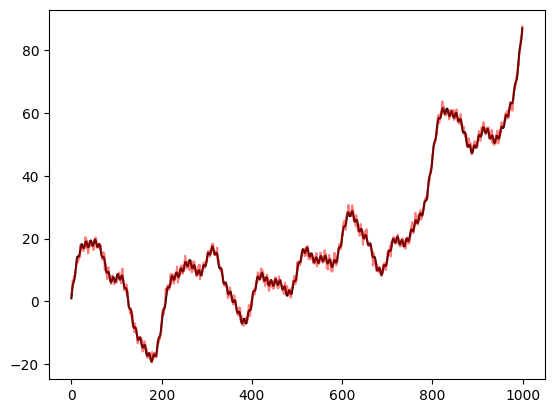

In [2]:
plt.plot(ground_truth, color='black')
plt.plot(noisy_signal, color='red', alpha=0.5)

In [21]:
# Initialize models with larger capacity
pykan = PyKAN(width=[1, 8**2, 1], grid=5, k=3, seed=42)
effkan = EfficientKAN([1, 8**2, 1], grid_size=5, spline_order=3)
mlp = MLP(width=[1, 8**2, 1])  # Using same architecture as KAN models

# Training parameters
max_steps = 2000
learning_rate = 0.01
lr_patience = 20  # Steps to wait before adjusting learning rate
stopping_patience = 50  # Steps to wait before early stopping
min_delta = 1e-4  # Minimum improvement required

# Training loop with early stopping
models = [pykan, effkan, mlp]
model_names = ["PyKAN", "EfficientKAN", "MLP"]
model_colors = ['b', 'r', 'g']
best_models = []

for i, (model, name) in enumerate(zip(models, model_names)):
    print(f"\nTraining {name}:")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_loss = float('inf')
    best_state = None
    lr_counter = 0
    stopping_counter = 0
    current_lr = learning_rate
    
    status_message = ""
    
    for step in range(max_steps):
        optimizer.zero_grad()
        output = model(train_indices)
        loss = torch.nn.functional.mse_loss(output, train_values)
        loss.backward()
        optimizer.step()
        
        # Early stopping and LR adjustment check
        if loss.item() < best_loss - min_delta:
            best_loss = loss.item()
            best_state = model.state_dict().copy()
            lr_counter = 0
            stopping_counter = 0
        else:
            lr_counter += 1
            stopping_counter += 1
            
            # Adjust learning rate after lr_patience steps
            if lr_counter >= lr_patience:
                current_lr *= 0.5
                for param_group in optimizer.param_groups:
                    param_group['lr'] = current_lr
                status_message = f" | EarlyStopping: {stopping_counter}/{stopping_patience}, LR adjusted to {current_lr}"
                lr_counter = 0
            
        if stopping_counter >= stopping_patience:
            print(f"\nEarly stopping at step {step+1}")
            break
            
        if step % 10 == 0:
            print(f"\rStep {step+1}/{max_steps}, Loss: {loss.item():.6f}, LR: {optimizer.param_groups[0]['lr']:.6f}{status_message}", end="")
    
    if best_state is not None:
        model.load_state_dict(best_state)
    best_models.append(model)

checkpoint directory created: ./model
saving model version 0.0

Training PyKAN:
Step 871/2000, Loss: 0.008631, LR: 0.001250 | EarlyStopping: 40/50, LR adjusted to 0.00125
Early stopping at step 875

Training EfficientKAN:
Step 611/2000, Loss: 0.009857, LR: 0.001250 | EarlyStopping: 40/50, LR adjusted to 0.00125
Early stopping at step 614

Training MLP:
Step 751/2000, Loss: 0.133107, LR: 0.001250 | EarlyStopping: 40/50, LR adjusted to 0.00125
Early stopping at step 759


In [22]:
# Evaluation and visualization
with torch.no_grad():
    predictions = []
    for model in best_models:
        # Predict entire sequence and denormalize
        pred = model(time_indices)
        pred = pred * data_std + data_mean
        predictions.append(pred)
        print(f"{name} prediction shape: {pred.shape}")
    
    # Calculate noisy_mse for test period
    noisy_mse = torch.nn.functional.mse_loss(
        torch.FloatTensor(noisy_signal[train_size:]),
        torch.FloatTensor(ground_truth[train_size:])
    )

MLP prediction shape: torch.Size([1000, 1])
MLP prediction shape: torch.Size([1000, 1])
MLP prediction shape: torch.Size([1000, 1])


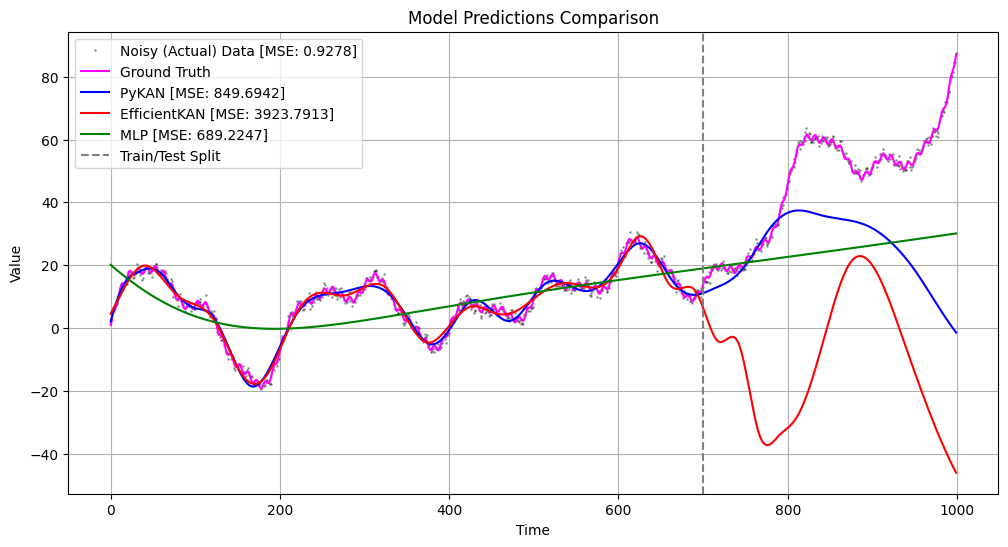

In [23]:
# Visualization
plt.figure(figsize=(12, 6))

# Plot noisy signal and ground truth
plt.plot(noisy_signal, 'k.', alpha=0.3, markersize=2, label=f'Noisy (Actual) Data [MSE: {round(noisy_mse.item(), 4)}]')
plt.plot(ground_truth, color='magenta', label='Ground Truth')

# Plot predictions for KAN models
for i, (pred, name, color) in enumerate(zip(predictions, model_names, model_colors)):
    mse = torch.nn.functional.mse_loss(
        pred[train_size:], 
        torch.FloatTensor(ground_truth[train_size:]).reshape(-1, 1)
    ).item()
    
    plt.plot(range(len(pred)), 
             pred.squeeze().numpy(), 
             color=color,
             label=f'{name} [MSE: {round(mse, 4)}]')

plt.axvline(x=train_size, color='gray', linestyle='--', label='Train/Test Split')

plt.title(f'Model Predictions Comparison')
plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()
